# [08] 기타 Activation Map들의 소개

`Grad CAM` 이전의 혹은 또다른 Activation Map들에 대해서 소개하겠습니다.

In [47]:
import copy
import os

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import seaborn as sns

from materials.mobilenetv2 import mobilenet_v2

# Occlusion

- [Occlusion 자료](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf )
    - 이미지의 어떤 pixel을 더 높은 확률로 예측하고자 하는지를 보기 위한 시각화 기법 중 하나입니다.
    - Occlusion의 접근은 다음과 같습니다.
        1. 직사각형으로 사진의 일부분을 도려냈을 때, 도려낸 사진의 확률을 기록함.
        2. 1번의 확률을 직사각형을 이동시켜보면서 계속해서 얻어봄.
        3. 1,2번을 통해 얻어지는 확률들로 새롭게 heatmap을 만들어보고, 이 heatmap을 occlusion이라 부름.

## Occlusion의 해석

- 위의 방법론에서 알 수 있듯이, 도려냈을 때 가장 낮은 값을 가지는 부분에 object가 있을 것이라 기대함.
- 혹은 분류에서 가장 중요한 역할을 하는 부분이 있을 것이라 기대함.

In [41]:
#custom function to conduct occlusion experiments
def get_occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = ?????????????
            w_start = ?????????????
            h_end = ?????????????
            w_end = ?????????????
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = ?????????????
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

# Saliency map
- [Saliency 자료](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf )
- __Saliency map__은 input image의 label에 대한 gradient를 시각화하는 기법입니다.
    - model을 sgd로 학습할 때, input image는 원래 gradient를 구하지 않습니다.
    - 하지만, 인위적으로 input에 대한 gradient를 계산해보면, pixel마다 가지는 gradient가 다릅니다.
    - gradient가 큰 픽셀은 상대적으로 label과 관련이 없는 부분이고,
    - gradient가 작은 픽셀은 상대적으로 label과 굉장히 관련이 있는 부분을 의미합니다.

In [42]:
def get_saliency_map(model, test_loader):
    device = 'cuda:0'
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    
    data = next(iter(test_loader))
    image = data[0].type(torch.FloatTensor).to(device)
    image.requires_grad_()
    label = data[1].type(torch.LongTensor).to(device)
    pred_label = model(image)

    loss = criterion(pred_label, label)
    loss.backward()
    
    saliency = image.grad
    saliency = ?????????????
    saliency, _ = ?????????????
    
    return data, pred_label, saliency

---

In [4]:
def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device

In [17]:
#device = get_device(cuda=True)
device = 'cpu'

In [29]:
TEST_DATA_PATH = './COVID19-DATASET/test/'
batch_size=5
test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=batch_size)
class_names = testloader.dataset.classes

In [30]:
model = mobilenet_v2(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

In [31]:
model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


In [32]:
for params in model.parameters():
    params.requires_grad = False

In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()

std_correction = np.asarray([0.5, 0.5, 0.5]).reshape(3, 1, 1)

#define mean correction to be made
mean_correction = np.asarray([0.5, 0.5, 0.5]).reshape(3, 1, 1)

#convert the tensor img to numpy img and de normalize 
raw_images = np.multiply(images.numpy(), std_correction) + mean_correction
print(raw_images.shape)
raw_images = raw_images.transpose(0, 2,3,1)
print(raw_images.shape)
images = images.to(device)

(5, 3, 150, 150)
(5, 150, 150, 3)


In [34]:
#custom function to fetch images from dataloader

def show_batch_images(model, dataloader):
    images,_ = next(iter(dataloader))

    #run the model on the images
    outputs = model(images)

    #get the maximum class 
    _, pred = torch.max(outputs.data, 1)
    print(outputs.shape)
    #make grid
    img = torchvision.utils.make_grid(images)

    #call the function
    imshow(img, title=[class_names[x.item()] for x in pred])

    return images, pred

In [35]:
def imshow(img, title):
  
    """Custom function to display the image using matplotlib"""

    #define std correction to be made
    std_correction = np.asarray([0.5, 0.5, 0.5]).reshape(3, 1, 1)

    #define mean correction to be made
    mean_correction = np.asarray([0.5, 0.5, 0.5]).reshape(3, 1, 1)

    #convert the tensor img to numpy img and de normalize 
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction

    #plot the numpy image
    plt.figure(figsize = (batch_size * 4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

torch.Size([5, 2])


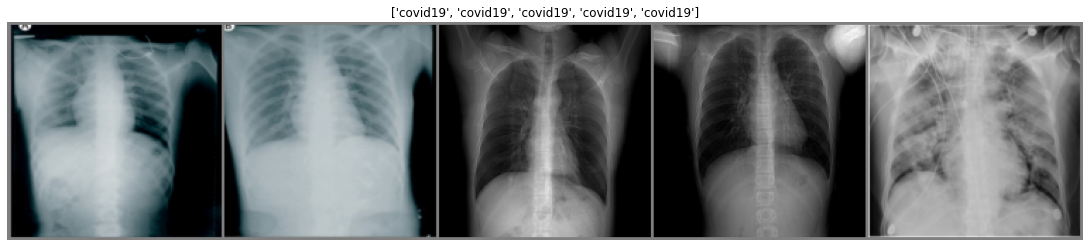

In [36]:
images, pred = show_batch_images(model, testloader)

In [37]:
#running inference on the images without occlusion

#vgg16 pretrained model
outputs = model(images)
print(outputs.shape)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = [prob_no_occ[i].item() for i in range(batch_size)]


print(prob_no_occ)

torch.Size([5, 2])
[0.9999996423721313, 0.9999996423721313, 0.9971169233322144, 0.9987891316413879, 0.9999676942825317]


In [44]:
def numpy_img(img):
  
    """Custom function to display the image using matplotlib"""

    #define std correction to be made
    std_correction = np.asarray([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)

    #define mean correction to be made
    mean_correction = np.asarray([0.247, 0.243, 0.261]).reshape(3, 1, 1)

    #convert the tensor img to numpy img and de normalize 
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction
    
    return npimg

In [43]:
for i in range(batch_size):
    if i==0:
        heatmaps = get_occlusion(model, images[i].unsqueeze(0), pred[i].item(), 16, 1).unsqueeze(0)
    else:
        heatmap = get_occlusion(model, images[i].unsqueeze(0), pred[i].item(), 16, 1).unsqueeze(0)
        heatmaps = torch.cat((heatmaps, heatmap), dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


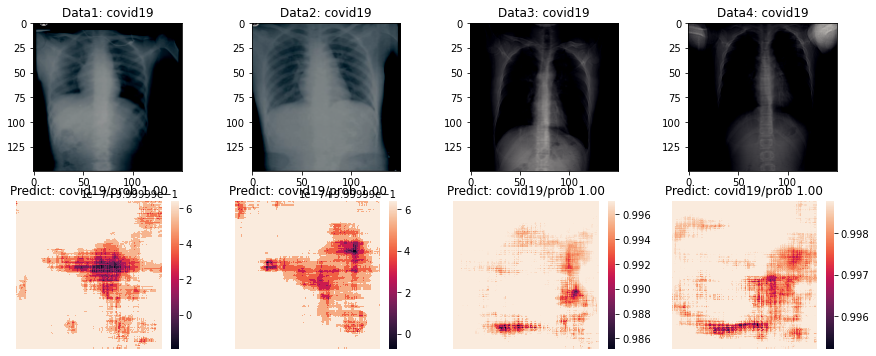

In [48]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(241, title='Data1: '+ class_names[labels[0].item()])
ax2 = fig.add_subplot(242, title='Data2: '+ class_names[labels[1].item()])
ax3 = fig.add_subplot(243, title='Data3: '+ class_names[labels[2].item()])
ax4 = fig.add_subplot(244, title='Data4: '+ class_names[labels[3].item()])

ax5 = fig.add_subplot(245, title='Predict: '+ class_names[pred[0].item()]+ '/prob {:.2f}'.format(prob_no_occ[0]))
ax6 = fig.add_subplot(246, title='Predict: '+ class_names[pred[1].item()]+ '/prob {:.2f}'.format(prob_no_occ[1]))
ax7 = fig.add_subplot(247, title='Predict: '+ class_names[pred[2].item()]+ '/prob {:.2f}'.format(prob_no_occ[2]))
ax8 = fig.add_subplot(248, title='Predict: '+ class_names[pred[3].item()]+ '/prob {:.2f}'.format(prob_no_occ[3]))

ax1.imshow(np.transpose(numpy_img(images[0]), (1, 2, 0)))
ax2.imshow(np.transpose(numpy_img(images[1]), (1, 2, 0)))
ax3.imshow(np.transpose(numpy_img(images[2]), (1, 2, 0)))
ax4.imshow(np.transpose(numpy_img(images[3]), (1, 2, 0)))

sns.heatmap(heatmaps[0], xticklabels=False, yticklabels=False, vmax=prob_no_occ[0], ax=ax5)
sns.heatmap(heatmaps[1], xticklabels=False, yticklabels=False, vmax=prob_no_occ[1], ax=ax6)
sns.heatmap(heatmaps[2], xticklabels=False, yticklabels=False, vmax=prob_no_occ[2], ax=ax7)
sns.heatmap(heatmaps[3], xticklabels=False, yticklabels=False, vmax=prob_no_occ[3], ax=ax8)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


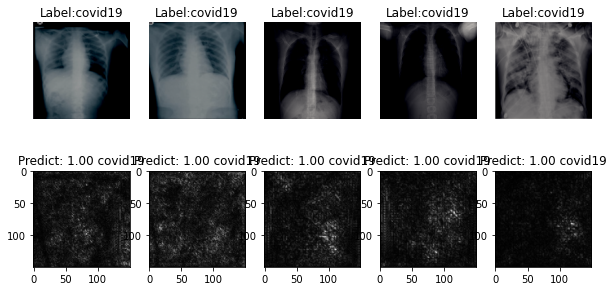

In [50]:
model = model.to('cuda:0')
data, pred_label, saliency = get_saliency_map(model, testloader)

pred_label = nn.functional.softmax(pred_label, dim=1)
prob_no_occ, pred = torch.max(pred_label.data, 1)

saliency = saliency.cpu().numpy()

N = saliency.shape[0]
f = plt.figure(figsize=(10,5))
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(np.transpose(numpy_img(data[0][i].cpu()), (1,2,0)))
    plt.axis('off')
    plt.title('Label:' + class_names[data[1][i]])
    
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.gray)
    plt.title('Predict: {:.2f} '.format(prob_no_occ[i]) + class_names[data[1][i]])